In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
from datetime import timedelta

from urllib.request import urlopen
import json

from plotly.express import choropleth as px_choropleth
from plotly.express import colors as px_colors

In [2]:
def mdy(date):
    month = date.month
    if(month<10): month = '0'+str(month)
    
    day = date.day
    if(day<10): day = '0'+str(day)
        
    year = date.year
    
    return str(month)+'-'+str(day)+'-'+str(year)

def daysBack(date, days):
    return date-timedelta(days=days)

def daysForward(date, days):
    return date+timedelta(days=days)

def days_between(d1, d2):
    return abs((d2 - d1).days)

In [3]:
now = datetime.datetime.now().replace(microsecond=0, second=0, minute=0, hour=0)
begin = datetime.datetime(2020, 3, 22)
day = timedelta(days=1)
btw = days_between(begin, datetime.datetime.now())

In [4]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/'
csv = '.csv'

In [5]:
i = 1
df = pd.read_csv(url+mdy(begin)+csv, 
                 parse_dates=['Last_Update'],
                 dtype={'FIPS': str})
adjFip = []
for fip in df['FIPS']:
    if isinstance(fip, float) == False:
        if len(fip)==4: 
            fip = '0'+fip
    adjFip.append(fip)
df['FIPS']=adjFip

while i < btw:
    print(i)
    site = url+mdy(begin+timedelta(days=i))+csv
    df_temp = pd.read_csv(site, 
                          parse_dates=['Last_Update'],
                          dtype={'FIPS':str})
    adjFip = []
    for fip in df_temp['FIPS']:
        if isinstance(fip, float) == False:
            if len(fip)==4: 
                fip = '0'+fip
        adjFip.append(fip)
    df_temp['FIPS']=adjFip
    
    df_temp['Last_Update'] = df_temp['Last_Update'].dt.floor('d')

    df = df.append(df_temp)
    i = i + 1

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114


In [6]:
df['Last_Update'] = df['Last_Update'].dt.floor('d')

In [7]:
df = df[df['Country_Region']=='US']
df = df[['FIPS', 'Admin2', 'Province_State', 'Last_Update', 'Confirmed', 'Deaths']]
df = df.reset_index(drop=True)

In [8]:
df.tail(10)

FIPS   Admin2            Province_State Last_Update  Confirmed  \
340647  46137  Ziebach              South Dakota  2020-07-15          3   
340648  88888      NaN          Diamond Princess  2020-07-15         49   
340649  99999      NaN            Grand Princess  2020-07-15        103   
340650     66      NaN                      Guam  2020-07-15        312   
340651     69      NaN  Northern Mariana Islands  2020-07-15         36   
340652     72      NaN               Puerto Rico  2020-07-15      10123   
340653    NaN      NaN                 Recovered  2020-07-15          0   
340654     78      NaN            Virgin Islands  2020-07-15        206   
340655  16061    Lewis                     Idaho  2020-07-10          1   
340656  41069  Wheeler                    Oregon  2020-07-06          0   

        Deaths  
340647       0  
340648       0  
340649       3  
340650       5  
340651       2  
340652     169  
340653       0  
340654       6  
340655       0  
340656       0

In [9]:
def rev_sum(arr):
    arr = arr.reset_index(drop=True)
    ret = np.arange(len(arr))
    for i in range(0, len(arr)-1, 1):
        ret[i+1]=abs(arr[i]-arr[i+1])
        ret[0]=arr[0]
    return ret

In [10]:
#add running weekly average
list1 = df['FIPS'].unique().tolist()
list1.remove(np.nan)
frames = []

for county in list1:
    df_temp = df[df['FIPS']==county]
    df_temp = df_temp.sort_values(by='Last_Update')
    
    #first add the daily number for each county
    df_temp['newCases'] = rev_sum(df_temp['Confirmed'])
    df_temp['newDeaths'] = rev_sum(df_temp['Deaths'])
    
#     df_temp = df_temp.iloc[::-1]
    df_temp['weekly case avg'] = df_temp['newCases'].rolling(window=7).mean()
    df_temp['weekly death avg'] = df_temp['newDeaths'].rolling(window=7).mean()

    df_temp['case proportion'] = df_temp['weekly case avg']/df_temp['weekly case avg'].max()
    df_temp['death proportion'] = df_temp['weekly death avg']/df_temp['weekly death avg'].max()

    try:
        df_temp['peak case day'] = df_temp[df_temp['case proportion'] == 1]['Last_Update'].iloc[-1]
    except:
        print('no peak cases...')

    df_temp = df_temp.drop_duplicates(subset=['Last_Update'])
    frames.append(df_temp)
    print('Done: '+str(county))
    
df2 = pd.concat(frames)
df2.head(10)

Done: 36061
Done: 36059
Done: 36119
Done: 36103
Done: 36087
Done: 36071
Done: 36001
Done: 36027
Done: 36055
Done: 36029
Done: 36067
Done: 36091
Done: 36093
Done: 36079
Done: 36083
Done: 36111
Done: 36021
Done: 36109
Done: 36105
Done: 36063
Done: 36065
Done: 36069
Done: 36019
Done: 36043
Done: 36007
Done: 36057
Done: 36031
Done: 36117
Done: 36039
Done: 36003
Done: 36121
Done: 36041
Done: 36017
Done: 36101
Done: 36051
Done: 36023
Done: 36025
Done: 36107
Done: 36037
Done: 36113
Done: 36115
Done: 36095
Done: 36035
Done: 36045
Done: 53033
Done: 53061
Done: 53053
Done: 53057
Done: 53029
Done: 53063
Done: 53025
Done: 53035
Done: 53077
Done: 53073
Done: 53067
Done: 53011
Done: 53005
Done: 53031
Done: 53037
Done: 53039
Done: 53009
Done: 53015
Done: 53007
Done: 53021
Done: 53041
Done: 53027
Done: 53013
Done: 53043
Done: 53045
Done: 53071
Done: 53065
Done: 53055
Done: 53075
Done: 34003
Done: 34013
Done: 34025
Done: 34023
Done: 34017
Done: 34039
Done: 34027
Done: 34029
Done: 34031
Done: 34035
Done

Done: 51800
Done: 51001
Done: 51117
Done: 51163
Done: 51093
Done: 51067
Done: 51590
Done: 51019
Done: 51009
Done: 51065
Done: 51109
Done: 28049
Done: 28033
Done: 28047
Done: 28035
Done: 28109
Done: 28089
Done: 28083
Done: 28027
Done: 28139
Done: 28121
Done: 28051
Done: 28081
Done: 28059
Done: 28071
Done: 28029
Done: 28045
Done: 28085
Done: 28087
Done: 28011
Done: 28157
Done: 28037
Done: 28093
Done: 28113
Done: 28057
Done: 28151
Done: 28095
Done: 28147
Done: 28159
Done: 28077
Done: 28043
Done: 28107
Done: 28143
Done: 28105
Done: 28133
Done: 28111
Done: 28067
Done: 28129
Done: 28163
Done: 28053
Done: 28155
Done: 28001
Done: 28025
Done: 28039
Done: 28007
Done: 28079
Done: 28127
Done: 28145
Done: 28017
Done: 28097
Done: 28115
Done: 28123
Done: 28137
Done: 18097
Done: 18057
Done: 18081
Done: 18089
Done: 18063
Done: 18141
Done: 18067
Done: 18005
Done: 18047
Done: 18019
Done: 18003
Done: 18039
Done: 18011
Done: 18043
Done: 18091
Done: 18157
Done: 18095
Done: 18167
Done: 18053
Done: 18035
Done

Done: 13071
Done: 13075
Done: 13079
Done: 13081
Done: 13083
Done: 13087
Done: 13091
Done: 13093
Done: 13101
Done: 13105
Done: 13107
Done: 13109
Done: 13111
Done: 13119
Done: 13123
Done: 13125
Done: 13131
Done: 13133
Done: 13137
Done: 13141
Done: 13143
Done: 13145
Done: 13147
Done: 13155
Done: 13157
Done: 13159
Done: 13161
Done: 13163
Done: 13165
Done: 13167
Done: 13169
Done: 13173
Done: 13179
Done: 13183
Done: 13193
Done: 13195
Done: 13197
Done: 13189
Done: 13191
Done: 13199
Done: 13205
Done: 13209
Done: 13211
Done: 13213
Done: 13221
Done: 13229
Done: 13231
Done: 13235
Done: 13237
Done: 13239
Done: 13241
Done: 13249
Done: 13251
Done: 13253
Done: 13257
Done: 13259
Done: 13263
Done: 13265
Done: 13267
Done: 13269
Done: 13271
Done: 13275
Done: 13279
Done: 13281
Done: 13283
Done: 13291
Done: 13293
Done: 13295
Done: 13297
Done: 13299
Done: 13301
Done: 13303
Done: 13305
Done: 13307
Done: 13309
Done: 13311
Done: 13315
Done: 13317
Done: 13319
Done: 15001
no peak cases...
Done: 15005
Done: 16003

Done: 28099
Done: 28101
Done: 28103
Done: 28117
Done: 28119
Done: 28125
Done: 28131
Done: 28135
Done: 28141
Done: 28149
Done: 28153
Done: 28161
Done: 29003
Done: 29005
Done: 29007
Done: 29009
Done: 29011
Done: 29015
Done: 29017
Done: 29021
Done: 29023
Done: 29025
Done: 29027
Done: 29029
Done: 29031
Done: 29033
Done: 29035
Done: 29039
Done: 29041
Done: 29045
Done: 29047
Done: 29049
Done: 29053
Done: 29055
Done: 29057
Done: 29059
Done: 29061
Done: 29063
Done: 29065
Done: 29067
Done: 29071
Done: 29073
Done: 29075
Done: 29079
Done: 29081
Done: 29085
Done: 29087
Done: 29089
Done: 29091
Done: 29093
Done: 29099
Done: 29103
Done: 29105
Done: 29107
Done: 29109
Done: 29111
Done: 29113
Done: 29115
Done: 29117
Done: 29121
Done: 29123
Done: 29125
Done: 29127
Done: 29119
Done: 29129
Done: 29131
Done: 29133
Done: 29135
Done: 29137
Done: 29139
Done: 29141
Done: 29143
Done: 29145
Done: 29147
Done: 29149
Done: 29151
Done: 29153
Done: 29155
Done: 29157
Done: 29159
Done: 29161
Done: 29163
Done: 29165
Done

Done: 47069
Done: 47071
Done: 47073
Done: 47075
Done: 47077
Done: 47079
Done: 47081
Done: 47085
Done: 47087
Done: 47091
Done: 47095
Done: 47097
Done: 47099
Done: 47101
Done: 47103
Done: 47111
Done: 47113
Done: 47117
Done: 47109
Done: 47121
Done: 47127
Done: 47129
Done: 47131
Done: 47133
Done: 47137
Done: 47139
Done: 47143
Done: 47153
Done: 47159
Done: 47161
Done: 47169
Done: 47171
Done: 47173
Done: 47175
Done: 47177
Done: 47181
Done: 47183
Done: 47185
Done: 48001
Done: 48003
Done: 48005
Done: 48007
Done: 48009
Done: 48011
Done: 48015
Done: 48017
Done: 48019
Done: 48021
Done: 48023
Done: 48025
Done: 48031
no peak cases...
Done: 48033
Done: 48035
Done: 48043
Done: 48045
Done: 48047
Done: 48051
Done: 48055
Done: 48057
Done: 48059
Done: 48063
Done: 48065
Done: 48067
Done: 48073
Done: 48075
Done: 48077
Done: 48079
Done: 48081
Done: 48083
Done: 48087
Done: 48089
Done: 48093
Done: 48095
Done: 48097
Done: 48099
Done: 48101
Done: 48105
Done: 48107
Done: 48109
Done: 48111
Done: 48115
Done: 48119

FIPS         Admin2 Province_State Last_Update  Confirmed  Deaths  \
0      36061  New York City       New York  2020-03-22       9654      63   
5245   36061  New York City       New York  2020-03-23      12305      99   
8422   36061  New York City       New York  2020-03-24      14904     131   
11599  36061  New York City       New York  2020-03-25      17856     199   
14775  36061  New York City       New York  2020-03-26      21873     281   
17949  36061  New York City       New York  2020-03-27      25573     366   
21130  36061  New York City       New York  2020-03-28      29776     517   
24308  36061  New York City       New York  2020-03-29      33768     678   
27490  36061  New York City       New York  2020-03-30      37453     790   
30007  36061  New York City       New York  2020-03-31      43119     932   

       newCases  newDeaths  weekly case avg  weekly death avg  \
0          9654         63              NaN               NaN   
5245       2651         36              NaN               NaN   
8422       2599         32              NaN               NaN   
11599      2952         68              NaN               NaN   
14775      4017         82              NaN               NaN   
17949      3700         85              NaN               NaN   
21130      4203        151      4253.714286         73.857143   
24308      3992        161      3444.857143         87.857143   
27490      3685        112      3592.571429         98.714286   
30007      5666        142      4030.714286        114.428571   

       case proportion  death proportion peak case day  
0                  NaN               NaN    2020-04-18  
5245               NaN               NaN    2020-04-18  
8422               NaN               NaN    2020-04-18  
11599              NaN               NaN    2020-04-18  
14775              NaN               NaN    2020-04-18  
17949              NaN               NaN    2020-04-18  
21130         0.799055          0.068450    2020-04-18  
24308         0.647112          0.081425    2020-04-18  
27490         0.674860          0.091487    2020-04-18  
30007         0.757165          0.106051    2020-04-18

In [11]:
df2.columns

Index(['FIPS', 'Admin2', 'Province_State', 'Last_Update', 'Confirmed',
       'Deaths', 'newCases', 'newDeaths', 'weekly case avg',
       'weekly death avg', 'case proportion', 'death proportion',
       'peak case day'],
      dtype='object')

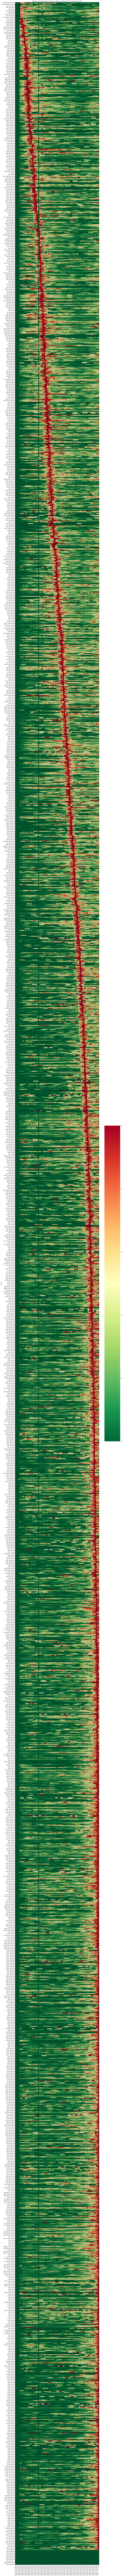

In [12]:
# dates = df2['peak case day']
# df2['pcd date'] = dates.apply(lambda x: try: x.strftime('%m-%d-%Y'))

df1 = df2.copy()
df1['County'] = df1['FIPS']+' ('+df1['Province_State']+')'

df1['weekly case avg'] = df1['weekly case avg'].fillna(0)
df1['weekly death avg'] = df1['weekly death avg'].fillna(0)
df1['case proportion'] = df1['case proportion'].fillna(0)
df1['death proportion'] = df1['death proportion'].fillna(0)

#how to sort all counties by peak case day
recent = df1[df1['Last_Update']==datetime.datetime(2020, 7, 13)]
val = recent.sort_values(by=['County'])[['County', 'peak case day']]
val = val.set_index('County')
val

county_heat = df1.pivot(index='County', columns='Last_Update', values='case proportion')
county_heat = county_heat.join(val, how='inner')
county_heat = county_heat.sort_values(by='peak case day')
county_heat = county_heat.drop(['peak case day'], axis=1)
county_heat = county_heat.fillna(0)

fig, ax = plt.subplots(figsize=(20,500))
sns.heatmap(county_heat, cmap='RdYlGn_r', vmin=0, vmax=1, linewidths=.005, linecolor='black')
plt.title('Proportion of Average Daily Cases over 1 Week, Organized by Date of Most Recent Peak')

fig.savefig('county/Normalized Weekly Average of Daily Cases')

In [13]:
county_heat

2020-03-22  2020-03-23  2020-03-24  2020-03-25  \
County                                                                     
99999 (Grand Princess)           0.0         0.0         0.0         0.0   
50003 (Vermont)                  0.0         0.0         0.0         0.0   
88888 (Diamond Princess)         0.0         0.0         0.0         0.0   
50017 (Vermont)                  0.0         0.0         0.0         0.0   
08051 (Colorado)                 0.0         0.0         0.0         0.0   
...                              ...         ...         ...         ...   
90036 (New York)                 0.0         0.0         0.0         0.0   
90038 (North Dakota)             0.0         0.0         0.0         0.0   
90042 (Pennsylvania)             0.0         0.0         0.0         0.0   
90048 (Texas)                    0.0         0.0         0.0         0.0   
90056 (Wyoming)                  0.0         0.0         0.0         0.0   

                          2020-03-26  2020-03-27  2020-03-28  2020-03-29  \
County                                                                     
99999 (Grand Princess)           0.0         0.0         1.0    0.719626   
50003 (Vermont)                  0.0         0.0         1.0    0.800000   
88888 (Diamond Princess)         0.0         0.0         1.0    0.000000   
50017 (Vermont)                  0.0         0.0         1.0    0.000000   
08051 (Colorado)                 0.0         0.0         1.0    0.863636   
...                              ...         ...         ...         ...   
90036 (New York)                 0.0         0.0         0.0    0.000000   
90038 (North Dakota)             0.0         0.0         0.0    0.000000   
90042 (Pennsylvania)             0.0         0.0         0.0    0.000000   
90048 (Texas)                    0.0         0.0         0.0    0.000000   
90056 (Wyoming)                  0.0         0.0         0.0    0.000000   

                          2020-03-30  2020-03-31  ...  2020-07-06  2020-07-07  \
County                                            ...                           
99999 (Grand Princess)      0.700935    0.700935  ...    0.000000    0.000000   
50003 (Vermont)             0.800000    0.600000  ...    0.133333    0.066667   
88888 (Diamond Princess)    0.000000    0.000000  ...    0.000000    0.000000   
50017 (Vermont)             0.000000    0.333333  ...    0.333333    0.333333   
08051 (Colorado)            0.772727    0.818182  ...    0.045455    0.045455   
...                              ...         ...  ...         ...         ...   
90036 (New York)            0.000000    0.000000  ...    0.000000    0.000000   
90038 (North Dakota)        0.000000    0.000000  ...    0.000000    0.000000   
90042 (Pennsylvania)        0.000000    0.000000  ...    0.000000    0.000000   
90048 (Texas)               0.000000    0.000000  ...    0.000000    0.000000   
90056 (Wyoming)             0.000000    0.000000  ...    0.000000    0.000000   

                          2020-07-08  2020-07-09  2020-07-10  2020-07-11  \
County                                                                     
99999 (Grand Princess)      0.000000    0.000000    0.000000    0.000000   
50003 (Vermont)             0.066667    0.066667    0.133333    0.066667   
88888 (Diamond Princess)    0.000000    0.000000    0.000000    0.000000   
50017 (Vermont)             0.333333    0.333333    0.333333    0.333333   
08051 (Colorado)            0.030303    0.030303    0.030303    0.060606   
...                              ...         ...         ...         ...   
90036 (New York)            0.000000    0.000000    0.000000    0.000000   
90038 (North Dakota)        0.000000    0.000000    0.000000    0.000000   
90042 (Pennsylvania)        0.000000    0.000000    0.000000    0.000000   
90048 (Texas)               0.000000    0.000000    0.000000    0.000000   
90056 (Wyoming)             0.000000    0.000000    0.000000    0.000000   

     

In [14]:
df_map = df2[df2['Last_Update']==datetime.datetime(2020,7,13)]
peakDates = df_map['peak case day']
df_map['daysSince'] = peakDates.apply(lambda x: days_between(x, datetime.datetime.now()))
df_map.head()

/Users/carterpace/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



FIPS         Admin2 Province_State Last_Update  Confirmed  Deaths  \
333242  36061  New York City       New York  2020-07-13     219051   23283   
333221  36059         Nassau       New York  2020-07-13      42307    2190   
334238  36119    Westchester       New York  2020-07-13      35297    1435   
333885  36103        Suffolk       New York  2020-07-13      42028    1993   
333629  36087       Rockland       New York  2020-07-13      13716     670   

        newCases  newDeaths  weekly case avg  weekly death avg  \
333242       341          5       297.428571         13.285714   
333221        40          0        39.428571          0.571429   
334238        37          2        36.285714          1.142857   
333885        41          0        55.142857          1.428571   
333629        16          0         9.714286          0.285714   

        case proportion  death proportion peak case day  daysSince  
333242         0.055872          0.012313    2020-04-18       88.0  
333221         0.028891          0.005348    2020-04-09       97.0  
334238         0.032254          0.018018    2020-03-28      109.0  
333885         0.037970          0.026525    2020-04-10       96.0  
333629         0.021303          0.012658    2020-04-06      100.0

In [15]:
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

In [ ]:
fig = px_choropleth(df_map,
                    geojson=counties,
                    locations='FIPS',
                    scope="usa",
                    color="daysSince",
                    color_continuous_scale=px_colors.sequential.YlOrRd_r,
                    title="Days Since Last Peak of New COVID-19 Cases (7-Day Average)"
                   )
fig.update_layout(margin={"r":0,"t":50,"l":20,"b":0})
fig.show()

fig.write_image("county/Days Since Last Peak.png", scale=5)

In [ ]:
fig = px_choropleth(df_map,
                    geojson=counties,
                    locations='FIPS',
                    scope="usa",
                    color="case proportion",
                    color_continuous_scale=px_colors.sequential.YlOrRd,
                    title="Percentage of Current Infection from Highest Infection per County"
                   )
fig.update_layout(margin={"r":0,"t":50,"l":20,"b":0})
fig.show()

fig.write_image("county/Current Peak Status.png", scale=5)

## Travis County

In [ ]:
#date labels
def county_plot(c):
    dates = []
    for d in c['Last_Update'].tolist():
        if d.day==1: dates.append(str(d.date()))
        else: dates.append('')

    x_val = np.arange(len(c['Last_Update']))

    #plotting
    fig, ax1 = plt.subplots(figsize=(20,8))

    ax1.set_xlabel('Date')
    ax1.set_ylabel('Daily Cases and Deaths')
    ax1.bar(x=x_val, bottom=0, height=c['newCases'], label='Daily Cases', color='c')
    ax1.bar(x=x_val, bottom=0, height=c['newDeaths'], label='Daily Deaths', color='r')
    ax1.plot(x_val, c['weekly case avg'],  label='Moving 7-Day Case Average', color='b', linestyle='dashed')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel('% of Tests Returned Positive')
    ax2.plot(x_val, c['Confirmed'],  label='Total Cases', color='k')

    plt.title('Daily Increase in Cases and Deaths for '
              +str(c['Admin2'].values.tolist()[0])
              +' County, '
              +str(c['Province_State'].values.tolist()[0]))
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.xticks(x_val, dates, rotation=30) 
    fig = plt.gcf()
    ax1.grid(axis='y')
    plt.show()
    fig.savefig('county/'
                +str(c['Admin2'].values.tolist()[0])
                +' County, '
                +str(c['Province_State'].values.tolist()[0]))

In [ ]:
travisTX = df1[df1['FIPS']=='48453']
orangeNC = df1[df1['FIPS']=='37135']
onslowNC = df1[df1['FIPS']=='37133']

In [ ]:
county_plot(travisTX)